In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import weight_norm
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import time
import pandas as pd
from torch.autograd import Variable
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from torch import Tensor
from torch.nn import _reduction as _Reduction

import sklearn.metrics as sm

from tsai.all import *
from tsai.inference import load_learner

import statistics

In [4]:
# Set the device
device = torch.device("cuda") if torch.backends.mps.is_available() else "cpu"
my_setup()


os              : macOS-10.16-x86_64-i386-64bit
python          : 3.8.18
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 2.2.0.dev20231006
cpu cores       : 8
threads per cpu : 1
RAM             : 16.0 GB
GPU memory      : N/A


### don't no the reason cannot use GPU of M1Pro chip

In [24]:
#change train and test dataset
#df = np.load('D://UGA//UGA research//sensor_data//full_data//ctru_20_21_22.npy')
df = pd.read_csv('/Users/racheldong/Desktop/Re_Ke/BedDot/df_train_SBP_100_130_single.csv')
df

,90,91,92,93,94,95,96,97,98,99,...,182,183,184,185,186,187,188,189,190,SBP
0,2.631631e-07,2.704338e-07,2.787640e-07,2.896984e-07,3.028919e-07,3.168016e-07,3.295002e-07,3.413637e-07,3.541440e-07,3.695955e-07,...,-1.036012e-07,-1.164837e-07,-1.260047e-07,-1.340985e-07,-1.407601e-07,-1.431690e-07,-1.394079e-07,-1.287354e-07,-1.119726e-07,109
1,-1.172150e-07,-1.343016e-07,-1.464728e-07,-1.522762e-07,-1.490734e-07,-1.343627e-07,-1.089887e-07,-7.636631e-08,-3.999303e-08,-2.937414e-09,...,-5.353996e-10,8.447128e-08,1.696035e-07,2.527933e-07,3.313624e-07,4.019164e-07,4.613755e-07,5.078508e-07,5.416572e-07,129
2,-1.936325e-07,-1.608108e-07,-1.301859e-07,-1.031333e-07,-8.156145e-08,-6.745972e-08,-6.107396e-08,-6.109480e-08,-6.590415e-08,-7.394860e-08,...,7.033043e-08,7.845215e-08,7.823157e-08,7.241914e-08,6.121449e-08,4.513271e-08,2.529361e-08,2.251722e-09,-2.345371e-08,113
3,3.433917e-07,2.898072e-07,2.386685e-07,1.912036e-07,1.498898e-07,1.174591e-07,9.423212e-08,7.797427e-08,6.592049e-08,5.550863e-08,...,-8.896852e-08,-1.799774e-07,-2.674001e-07,-3.467809e-07,-4.138670e-07,-4.647851e-07,-4.956580e-07,-5.019207e-07,-4.831183e-07,125
4,2.022093e-07,2.002051e-07,1.883343e-07,1.640819e-07,1.270390e-07,7.806756e-08,2.068685e-08,-4.239057e-08,-1.096386e-07,-1.791866e-07,...,-3.799766e-07,-2.823233e-07,-1.892085e-07,-1.012126e-07,-1.725946e-08,5.849511e-08,1.199365e-07,1.634753e-07,1.899464e-07,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18902,8.837687e-08,1.568055e-07,2.147196e-07,2.569826e-07,2.811439e-07,2.859506e-07,2.736774e-07,2.462753e-07,2.050376e-07,1.518752e-07,...,3.516716e-07,3.812762e-07,4.096234e-07,4.298423e-07,4.396565e-07,4.398472e-07,4.291000e-07,4.073217e-07,3.770300e-07,105
18903,-3.398624e-07,-3.615300e-07,-3.800370e-07,-3.925410e-07,-3.981711e-07,-3.972142e-07,-3.911815e-07,-3.798901e-07,-3.620051e-07,-3.363653e-07,...,1.275141e-07,1.245257e-07,1.197538e-07,1.171736e-07,1.152836e-07,1.136723e-07,1.135994e-07,1.146990e-07,1.157975e-07,108
18904,7.270270e-08,7.334098e-08,7.553902e-08,8.222702e-08,9.340408e-08,1.076523e-07,1.226211e-07,1.385926e-07,1.572201e-07,1.797576e-07,...,-8.005377e-08,-5.153119e-08,-2.464402e-08,-2.068571e-09,1.698548e-08,3.342736e-08,4.795143e-08,5.963305e-08,6.711580e-08,114
18905,-6.685351e-07,-7.568039e-07,-8.282649e-07,-8.771531e-07,-8.989328e-07,-8.899742e-07,-8.524525e-07,-7.907805e-07,-7.093103e-07,-6.128937e-07,...,7.976550e-08,7.584909e-08,7.282480e-08,6.868901e-08,6.431711e-08,6.117659e-08,5.991484e-08,6.009802e-08,6.098799e-08,129


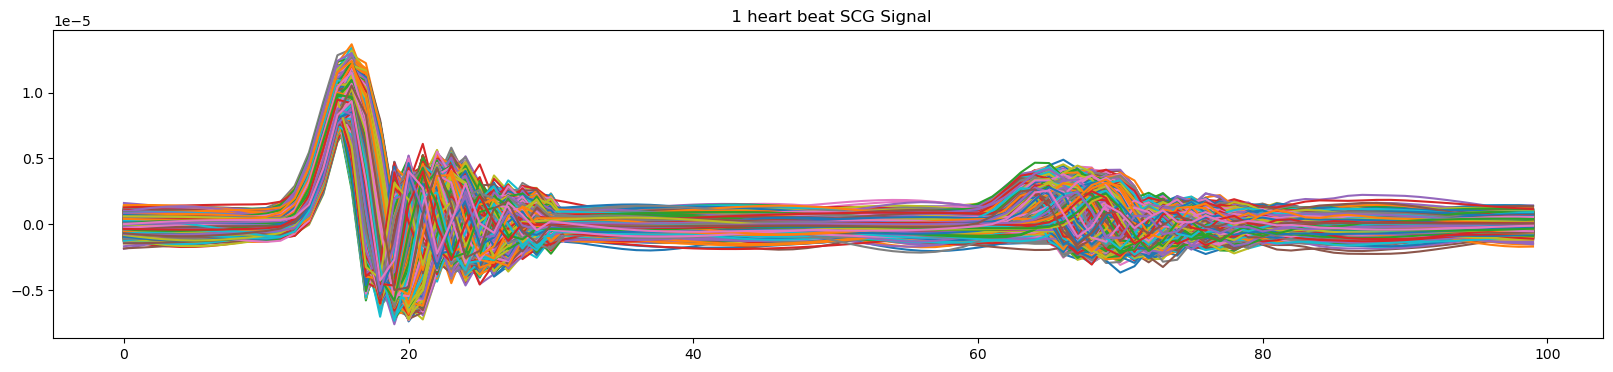

In [6]:
data = df.values
plt.figure(figsize=(20,4))
plt.plot(np.transpose(data[:,:100]))
plt.title(" 1 heart beat SCG Signal")
plt.show()

In [9]:
import pandas as pd
true_label = pd.DataFrame({'SBP':df['SBP']})
true_label
true_lable_sorted = true_label.sort_values('SBP')
true_lable_sorted = true_lable_sorted.reset_index(drop = True)
true_lable_sorted

,SBP
0,100
1,100
2,100
3,100
4,100
...,...
18902,130
18903,130
18904,130
18905,130


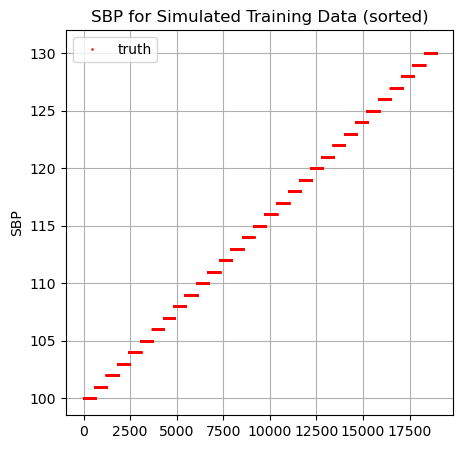

In [11]:
# sorted
plt.figure(figsize=(5,5))
plt.title('SBP for Simulated Training Data (sorted)')
plt.plot(true_lable_sorted,'ro',label='truth',markersize=0.8)
plt.ylim(top=132) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.legend(loc="upper left")
plt.grid()

In [15]:
mean_col_A = df['SBP'].mean()
mean_col_A

114.99862484793992

In [21]:
means = df.iloc[:, 0:101].mean()
means

90    -1.708502e-09
91    -1.681027e-09
92    -1.641417e-09
93    -1.601301e-09
94    -1.572826e-09
           ...     
186   -1.303678e-09
187   -1.115370e-09
188   -9.079712e-10
189   -7.272145e-10
190   -5.990880e-10
Length: 101, dtype: float64

In [23]:
means.to_csv('means.csv', index=False)

In [28]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
# Assuming 'data' is your dataset in NumPy array format
# Make sure 'data' has shape (18907, 101)

# Choose a bandwidth parameter (adjust as needed)
bandwidth = 0.5

# Create a kernel density estimator for your dataset
kde = gaussian_kde(data.T, bw_method=bandwidth)
# Create a range of x-values (assuming 100 points)
x_values = np.linspace(1, 101, 101)
# Estimate the probability density at each x-value
pdf_values = kde(x_values)
# Plot the estimated density curve
plt.figure(figsize=(10, 6))
plt.plot(x_values, pdf_values, label='Kernel Smoothed Density')
plt.xlabel('X-axis')
plt.ylabel('Density')
plt.title('Kernel Smoothed Density Estimation')
plt.legend()
plt.show()



LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

- ask the simulation settings from Bingnan(HR, RR, SBP, DBP)
- change the noise level to zero, check the true signal
- use col_mean to detect whether the cruve matches the true one
- use other non-parametric methods, like kernel smooth, to fit the cruve and check whether the fitted one matches the true one

In [4]:
# Get the current column names as a list
old_column_names = df.columns.tolist()

# Create a mapping dictionary to map old names to new names
new_column_names = {old_name: 'F' + old_name if old_name.isdigit() else old_name for old_name in old_column_names}
# Rename the columns using the mapping dictionary
df = df.rename(columns=new_column_names)

#Load column names
col_names = df.columns
feature_names = col_names[:-7]
print(feature_names)

full_df = pd.DataFrame(df, 
             columns=col_names)

Back_df = full_df[full_df["Action"] == "go_to_the_bed"]
Back_df = pd.DataFrame(Back_df, 
             columns=col_names)
print(len(Back_df))


# some constant features.
const_feature = []
for i in feature_names:
  if np.std(full_df[i]) < 1e-10:
    const_feature.append(i)
#print(const_feature)    
features = [e for e in feature_names if e not in const_feature]
targets = ["SBP"]


Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       ...
       'F991', 'F992', 'F993', 'F994', 'F995', 'F996', 'F997', 'F998', 'F999',
       'F1000'],
      dtype='object', length=1000)
8975


In [5]:
# Convert Unix timestamps to dates
full_df['Time'] = pd.to_datetime(full_df['Time']).dt.date
Back_df['Time'] = pd.to_datetime(Back_df['Time']).dt.date

print(Back_df)

            F1       F2       F3       F4       F5       F6       F7       F8  \
0     -23263.0  -7512.0  11456.0  29950.0  44021.0  55812.0  61418.0  55796.0   
1     -30235.0 -17579.0  -1601.0  15308.0  27720.0  37291.0  43908.0  41487.0   
2      14013.0  15736.0  17230.0  13814.0   6043.0    728.0    548.0   4973.0   
3      27295.0  34679.0  37292.0  25990.0  10342.0   5157.0   7095.0  12443.0   
4      -5726.0   5323.0  12356.0  17985.0  25981.0  30085.0  32987.0  35940.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
21856   1509.0  -1267.0   2579.0   -767.0 -11999.0  -7665.0  -2095.0   5580.0   
21857   3096.0   -125.0   6540.0   3835.0  -4155.0  -2185.0  -6019.0   4081.0   
21858 -18235.0 -37640.0 -21082.0 -14378.0   1451.0  13924.0  22153.0  27547.0   
21859 -19415.0 -33202.0 -19889.0 -17692.0  -5022.0  11825.0  23313.0  31354.0   
21860  -5522.0    762.0   6157.0  11677.0  19815.0  28395.0  35011.0  39830.0   

            F9      F10  ..

In [6]:
# Determine the total number of rows
total_rows = Back_df.shape[0]
print(total_rows)

# Calculate the number of rows for the new dataset
n = int(0.7 * total_rows)
# Retrieve the first n rows as a new dataset
train = Back_df.head(n)



# Calculate the number of rows for the last 30% subset
n = int(0.3 * total_rows)
# Calculate the starting index for the last 30% subset
start_index = total_rows - n
# Retrieve the last 30% subset as a new dataset
test = Back_df[start_index:]


# Split the dataframe into training and testing sets
print(len(train))
print(len(test))

8975
6282
2692


In [7]:
# some constant features.
const_feature = []
for i in feature_names:
  if np.std(train[i]) < 1e-10:
    const_feature.append(i)
#print(const_feature)    
features = [e for e in feature_names if e not in const_feature]
features_withS = []
for i in range(len(features)):
    features_withS.append(features[i])

train_columns = train.columns.tolist()
train_raw = train
train_SBP = train_raw[features_withS]
print(train_SBP)

targets = ["SBP"]
features_withS.append('SBP')

train_raw = train
train_SBP = train_raw[features_withS]
print(len(train_SBP))

test_columns = test.columns.tolist()
test_raw = test
test_SBP = test_raw[features_withS]
print(len(test_SBP))

train_dat_X = train_SBP[features]
train_dat_y = train_SBP['SBP']
test_dat_X = test_SBP[features]
test_dat_y = test_SBP['SBP']

#Get the mean and variance of X_train
#mean_train_X = train_dat_X.mean(axis = 0)
#std_train_X = train_dat_X.std(axis = 0)
#mean_train_X = train_dat_X.mean(axis = 1)
#std_train_X = train_dat_X.std(axis = 1)

#Get the mean and variance of y_train
#mean_train_y = train_dat_y.mean(axis = 0)
#std_train_y = train_dat_y.std(axis = 0)
#mean_train_y = train_dat_y.mean(axis = 1)
#std_train_y = train_dat_y.std(axis = 1)

#Normalize the input dataset by only training information
scaled_train_data_X = train_dat_X
scaled_train_data_y = train_dat_y
scaled_test_data_X = test_dat_X
scaled_test_data_y = test_dat_y

scaled_train_dat = pd.concat([scaled_train_data_X, scaled_train_data_y], axis=1)

scaled_train_data_X = scaled_train_dat[features]
scaled_train_data_y = scaled_train_dat['SBP']

sample_size = scaled_train_data_X.shape[0]
#sample_size_vali = scaled_vali_data_X.shape[0]
sample_size_test = scaled_test_data_X.shape[0]
#print(sample_size)

time_steps = scaled_train_data_X.shape[1]
#time_steps_vali = scaled_vali_data_X.shape[1]
time_steps_test = scaled_test_data_X.shape[1]
#print(time_steps)
#print(time_steps_vali)
#print(time_steps_test)

input_dimension = 1

#make the dataframe into np.array
scaled_train_data_X = np.array(scaled_train_data_X)
#scaled_vali_data_X = np.array(scaled_vali_data_X)
scaled_test_data_X = np.array(scaled_test_data_X)

scaled_train_data_y = np.array(scaled_train_data_y)
#scaled_vali_data_y = np.array(scaled_vali_data_y)
scaled_test_data_y = np.array(scaled_test_data_y)

#reshape the dataset
X_train_reshape = scaled_train_data_X.reshape(sample_size, time_steps, input_dimension)
#X_vali_reshape = scaled_vali_data_X.reshape(sample_size_vali, time_steps_vali, input_dimension)
X_test_reshape = scaled_test_data_X.reshape(sample_size_test, time_steps_test, input_dimension)

np.savetxt("D:/UGA//UGA research/sensor_data/VTCN/SBP_testing.csv", test_dat_y, delimiter=",")

            F1       F2       F3       F4       F5       F6       F7       F8  \
0     -23263.0  -7512.0  11456.0  29950.0  44021.0  55812.0  61418.0  55796.0   
1     -30235.0 -17579.0  -1601.0  15308.0  27720.0  37291.0  43908.0  41487.0   
2      14013.0  15736.0  17230.0  13814.0   6043.0    728.0    548.0   4973.0   
3      27295.0  34679.0  37292.0  25990.0  10342.0   5157.0   7095.0  12443.0   
4      -5726.0   5323.0  12356.0  17985.0  25981.0  30085.0  32987.0  35940.0   
...        ...      ...      ...      ...      ...      ...      ...      ...   
17502  18095.0  16843.0  14761.0   9909.0   3963.0    356.0   -366.0    472.0   
17503  33811.0  28909.0  21869.0  16094.0   9221.0   4018.0   6050.0  11491.0   
17504  32431.0  30983.0  28490.0  22890.0  18208.0  13828.0   8233.0   5981.0   
17505 -15190.0 -13484.0  -7290.0   -784.0   7557.0  18022.0  25464.0  32543.0   
17506  -7018.0 -12568.0 -10321.0  -3352.0   4887.0  11776.0  20362.0  26267.0   

            F9      F10  ..

In [8]:
#X_train_reshape = np.expand_dims(X_train_reshape, axis = -1)
#X_test_reshape = np.expand_dims(X_test_reshape, axis = -1)
# Transpose the dimensions
X_train_reshape = np.transpose(X_train_reshape, (0, 2, 1))
X_test_reshape = np.transpose(X_test_reshape, (0, 2, 1))
X_train_reshape.shape, X_test_reshape.shape

((6282, 1, 1000), (2692, 1, 1000))

In [9]:
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)

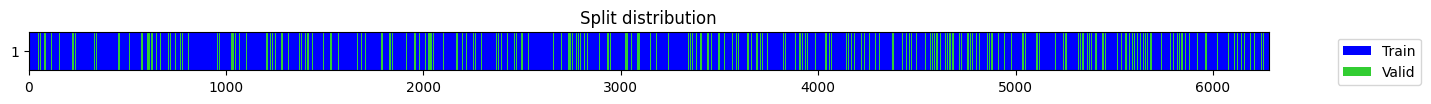

epoch,train_loss,valid_loss,mae,_rmse,time
0,15844.804688,15621.017578,123.913704,124.984085,00:05
1,15623.321289,15441.901367,123.186951,124.265450,00:03
2,15462.702148,15317.871094,122.681541,123.765388,00:03
3,15274.995117,15201.229492,122.207085,123.293274,00:03
4,15190.869141,15068.416992,121.665680,122.753479,00:03
5,15055.304688,14900.343750,120.976501,122.066963,00:03
6,14883.819336,14717.138672,120.221786,121.314224,00:03
7,14673.001953,14468.553711,119.188957,120.285294,00:03
8,14410.144531,14101.560547,117.652466,118.749985,00:03
9,14112.454102,13814.500000,116.442924,117.535095,00:03


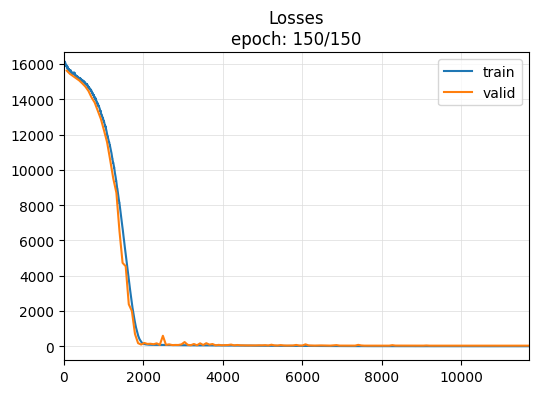

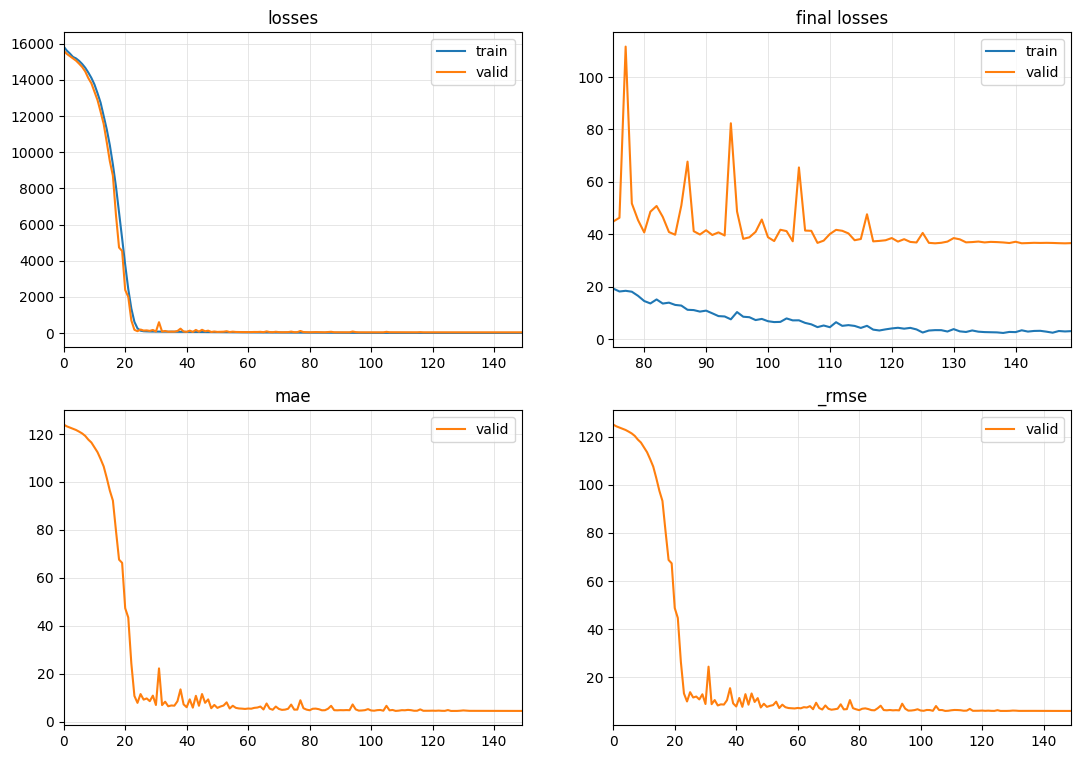

In [10]:
n_splits = 1
X = X_train_reshape
y = scaled_train_data_y

splits = get_splits(X, n_splits=n_splits, shuffle=True, check_splits=True)
  
dls = get_ts_dls(X, y, splits = splits, tfms=tfms, batch_tfms=batch_tfms, bs=64)
dls.one_batch()

learn2 = ts_learner(dls, ResNet, metrics=[mae, rmse], cbs=ShowGraph(), device= device)
learn2.fit_one_cycle(150, 1e-3)
learn2.export("reg_ResNet_BS64.pkl")

In [11]:
Predictions_train=learn2.get_X_preds(X_train_reshape)[0]

In [12]:
Predictions_test=learn2.get_X_preds(X_test_reshape)[0]

In [13]:
Pred_train_ori = Predictions_train
Pred_test_ori = Predictions_test

In [14]:
print(test_dat_y.values)
print(train_dat_y.values)

train_dat_y_values = train_dat_y.values
test_dat_y_values = test_dat_y.values

print(train_dat_y_values.shape)

[109. 112. 112. ... 131. 131. 136.]
[133. 133. 133. ... 113. 110. 110.]
(6282,)


In [15]:
np.savetxt("D:/UGA//UGA research/sensor_data/VTCN/D_ResNet_test_result_day.csv", Pred_test_ori, delimiter=",")
np.savetxt("D:/UGA//UGA research/sensor_data/VTCN/D_ResNet_train_result_day.csv", Pred_train_ori, delimiter=",")
np.savetxt("D:/UGA//UGA research/sensor_data/VTCN/D_ResNet_test_ori_day.csv", test_dat_y, delimiter=",")
np.savetxt("D:/UGA//UGA research/sensor_data/VTCN/D_ResNet_train_ori_day.csv", train_dat_y, delimiter=",")


In [16]:
results_table_train = pd.DataFrame({'train_true':train_dat_y, 'train_predicted':Pred_train_ori[:,0]},
                                   columns = ['train_true','train_predicted'])
results_table_test = pd.DataFrame({'test_true':test_dat_y, 'test_predicted':Pred_test_ori[:,0]}, 
                             columns = ['test_true','test_predicted'])

results_table_train_sorted = results_table_train.sort_values('train_true')
results_table_train_sorted = results_table_train_sorted.reset_index(drop = True)

results_table_test_sorted = results_table_test.sort_values('test_true')
results_table_test_sorted = results_table_test_sorted.reset_index(drop = True)
print(results_table_test_sorted)

      test_true  test_predicted
0          87.0      119.819672
1          87.0      115.213287
2          89.0      119.793777
3          92.0      114.909668
4          94.0      111.236130
...         ...             ...
2687      182.0      130.607239
2688      183.0      127.150124
2689      183.0      120.040833
2690      183.0      117.000366
2691      183.0      135.205124

[2692 rows x 2 columns]


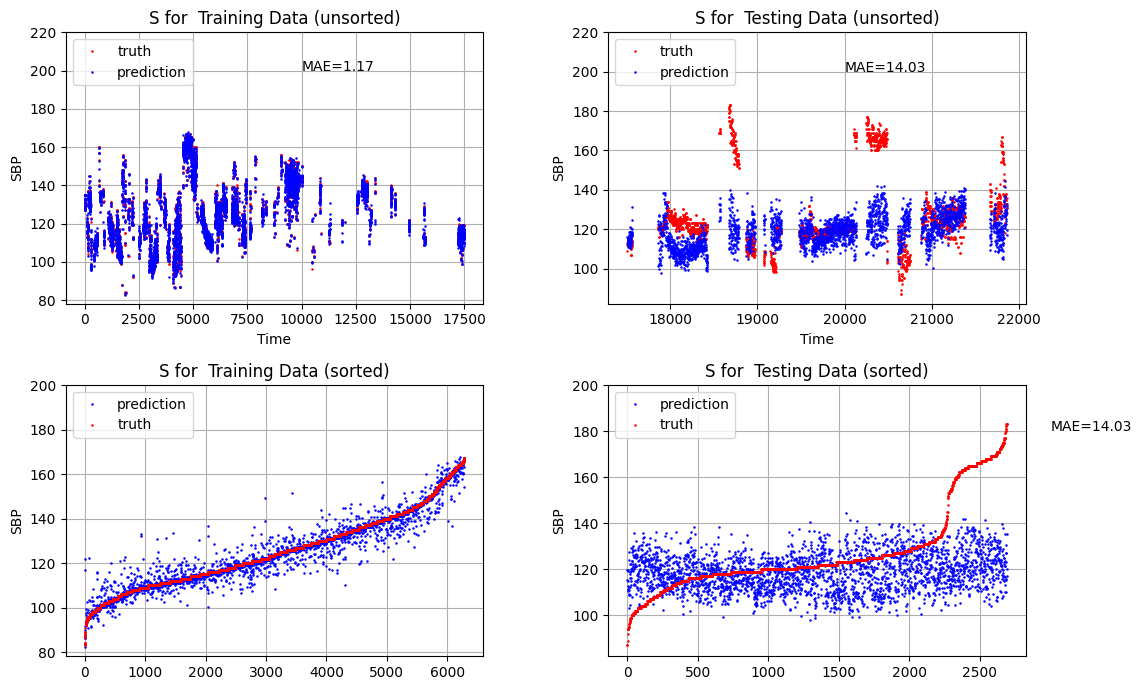

In [17]:
# MAE for training data
MAE_trainS=sm.mean_absolute_error(results_table_train.train_true,results_table_train.train_predicted)

# MAE for test data
MAE_testS=sm.mean_absolute_error(results_table_test.test_true,results_table_test.test_predicted)


plt.figure()
## unsorted
plt.subplot(221)
plt.title('S for  Training Data (unsorted)')
plt.plot(results_table_train.train_true,'ro',label='truth',markersize=0.8)
plt.plot(results_table_train.train_predicted,'bo',label='prediction',markersize=0.8)
plt.ylim(top=220) 
plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(10000,200,"MAE=" +str(round(MAE_trainS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplot(222)
plt.title('S for  Testing Data (unsorted)')
plt.plot(results_table_test.test_true,'ro',label='truth',markersize=0.8)
plt.plot(results_table_test.test_predicted,'bo',label='prediction',markersize=0.8)
plt.ylim(top=220) 
plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(20000,200,"MAE=" +str(round(MAE_testS,2)))
plt.legend(loc="upper left")
plt.grid()

# sorted
plt.subplot(223)
plt.title('S for  Training Data (sorted)')
plt.plot(results_table_train_sorted.train_predicted,'bo',label='prediction',markersize=0.8)
plt.plot(results_table_train_sorted.train_true,'ro',label='truth',markersize=0.8)
plt.ylim(top=200) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(10000,180,"MAE=" +str(round(MAE_trainS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplot(224)
plt.title('S for  Testing Data (sorted)')
plt.plot(results_table_test_sorted.test_predicted,'bo',label='prediction',markersize=0.8)
plt.plot(results_table_test_sorted.test_true,'ro',label='truth',markersize=0.8)
plt.ylim(top=200) 
#plt.xlabel("Time")
plt.ylabel("SBP")
plt.text(3000,180,"MAE=" +str(round(MAE_testS,2)))
plt.legend(loc="upper left")
plt.grid()

plt.subplots_adjust(top=1.6, bottom=0.30, left=0.10, right=1.60, hspace=0.30,
                    wspace=0.30)
plt.show()

In [18]:
#calculate MAE and MAPD
sum_abs = 0
MAPD_sum_abs = 0
abs_error_list = []
for k in range(len(train_dat_y_values)):
    err = train_dat_y_values[k]-Pred_train_ori[k,0]
    MAPD_temp = abs(err*100/train_dat_y_values[k])
    abs_err = abs(err)
    abs_error_list.append(abs_err.tolist())
    sum_abs = sum_abs + abs_err
    MAPD_sum_abs = MAPD_sum_abs + MAPD_temp
    
MAE_training = sum_abs/len(train_dat_y_values)
MAPD_training = MAPD_sum_abs/len(train_dat_y_values)
STD_training = statistics.pstdev(abs_error_list)
print(MAE_training)
print(MAPD_training)
print(STD_training)

sum_abs = 0
MAPD_sum_abs = 0
abs_error_list = []
for k in range(len(test_dat_y_values)):
    err = test_dat_y_values[k]-Pred_test_ori[k,0]
    MAPD_temp = abs(err*100/test_dat_y_values[k])
    abs_err = abs(err)
    abs_error_list.append(abs_err.tolist())
    sum_abs = sum_abs + abs_err
    MAPD_sum_abs = MAPD_sum_abs + MAPD_temp

STD_testing = statistics.pstdev(abs_error_list)
MAE_testing = sum_abs/len(test_dat_y_values)
MAPD_testing = MAPD_sum_abs/len(test_dat_y_values)
print(MAE_testing)
print(MAPD_testing)
print(STD_testing)

tensor(1.1734)
tensor(0.9516)
2.473027585253825
tensor(14.0316)
tensor(10.1986)
14.56046105815899


In [ ]:
kf = KFold(5, shuffle=False)
fold = 0
for train_index, test_index in kf.split(X_train_reshape):
    fold+=1
    print(f"Fold #{fold}")
    
    X_train = X_train_reshape[train_index]
    Y_train = scaled_train_data_y[train_index]
    X_vali = X_train_reshape[test_index]
    Y_vali = scaled_train_data_y[test_index]
    
    print(X_train.shape)
    print(Y_train.shape)
    
    
    #X_train, Y_train = tensor_converter(X_train, Y_train, input_channels)
    #X_vali, Y_vali = tensor_converter(X_vali, Y_vali, input_channels)
    X_train = (torch.Tensor(X_train))[:,np.newaxis]
    Y_train = (torch.Tensor(Y_train))
    X_vali = (torch.Tensor(X_vali))[:,np.newaxis]
    Y_vali = (torch.Tensor(Y_vali))
    
    X_train = X_train.to(device)
    Y_train = Y_train.to(device)
    X_vali = X_vali.to(device)
    Y_vali = Y_vali.to(device)
    
    print(X_train.shape)
    print(Y_train.shape)
    
    X, y, splits = combine_split_data([X_train, X_vali], [Y_train, Y_vali])
    
    dls = get_ts_dls(X, y, splits = splits, tfms=tfms, batch_tfms=batch_tfms, bs=128)
    #dls = dls.to("mps")
    dls.one_batch()
    
    check_data(X, y, splits)
    
    if fold == 1:
        learn2 = ts_learner(dls, RNN_FCN, metrics=[mae, rmse], cbs=ShowGraph(), device= "cpu")
        learn2.fit_one_cycle(3, 1e-3)
        learn2.export("reg_RNN_FCN.pkl")
    else:
        reg = load_learner("reg_RNN_FCN.pkl")
        reg = ts_learner(dls, RNN_FCN, metrics=[mae, rmse], cbs=ShowGraph(), device= "cpu")
        reg.fit_one_cycle(3, 1e-3)
        reg.export("reg_RNN_FCN.pkl")